In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
cd '/gdrive/My Drive/Colab Notebooks/Knight ML Assignment/Data/mydata'

/gdrive/My Drive/Colab Notebooks/Knight ML Assignment/Data/mydata


In [0]:
df=pd.read_csv('df1_train.csv')[['review_title','variety',]]

In [0]:
df.head()

,review_title,variety
0,Domaines Bunan 2014 Château la Rouvière Rosé (...,Rosé
1,Wieninger 2014 White (Wiener Gemischter Satz),White Blend
2,Tensley 2015 Colson Canyon Vineyard Syrah (San...,Syrah
3,Bodegas Luzón 2008 Red (Jumilla),Red Blend
4,Big Smooth 2014 Zinfandel (Lodi),Zinfandel


In [0]:
df['category_id']=df['variety'].factorize()[0]

In [0]:
category_id_df=df[['variety','category_id']].drop_duplicates().sort_values('category_id')

In [0]:
category_to_id = category_id_df.set_index('variety')['category_id'].to_dict()

In [0]:
id_to_category = category_id_df.set_index('category_id')['variety'].to_dict()

In [0]:
tfidf=TfidfVectorizer( sublinear_tf=True,min_df=10,norm='l2',ngram_range=(1,2),stop_words='english')

In [0]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
features = tfidf.fit_transform(df.review_title)

In [0]:
features.shape

(41319, 5734)

In [0]:
features=features.toarray()

In [0]:
labels=df.category_id

In [0]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for variety, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(variety))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bordeaux-style Red Blend':
  . Most correlated unigrams:
. médoc
. château
  . Most correlated bigrams:
. côtes bordeaux
. saint émilion
# 'Bordeaux-style White Blend':
  . Most correlated unigrams:
. barsac
. sauternes
  . Most correlated bigrams:
. 2016 bordeaux
. bordeaux blanc
# 'Cabernet Franc':
  . Most correlated unigrams:
. chinon
. franc
  . Most correlated bigrams:
. franc finger
. cabernet franc
# 'Cabernet Sauvignon':
  . Most correlated unigrams:
. sauvignon
. cabernet
  . Most correlated bigrams:
. sauvignon napa
. cabernet sauvignon
# 'Champagne Blend':
  . Most correlated unigrams:
. brut
. champagne
  . Most correlated bigrams:
. rosé champagne
. brut champagne
# 'Chardonnay':
  . Most correlated unigrams:
. chablis
. chardonnay
  . Most correlated bigrams:
. chardonnay russian
. vineyard chardonnay
# 'Gamay':
  . Most correlated unigrams:
. morgon
. beaujolais
  . Most correlated bigrams:
. georges duboeuf
. beaujolais villages
# 'Gewürztraminer':
  . Most correlat

Started Training LinearSVC
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Completed Training LinearSVC
Started Training MultinomialNB
Completed Training MultinomialNB


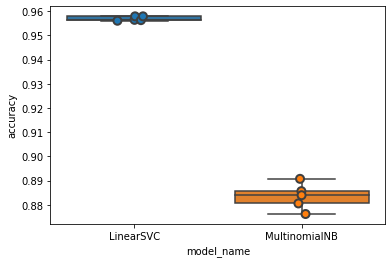

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    LinearSVC(verbose=1),
    MultinomialNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  print("Started Training {}".format(model_name))
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
  print("Completed Training {}".format(model_name))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC        0.956921
MultinomialNB    0.883419
Name: accuracy, dtype: float64

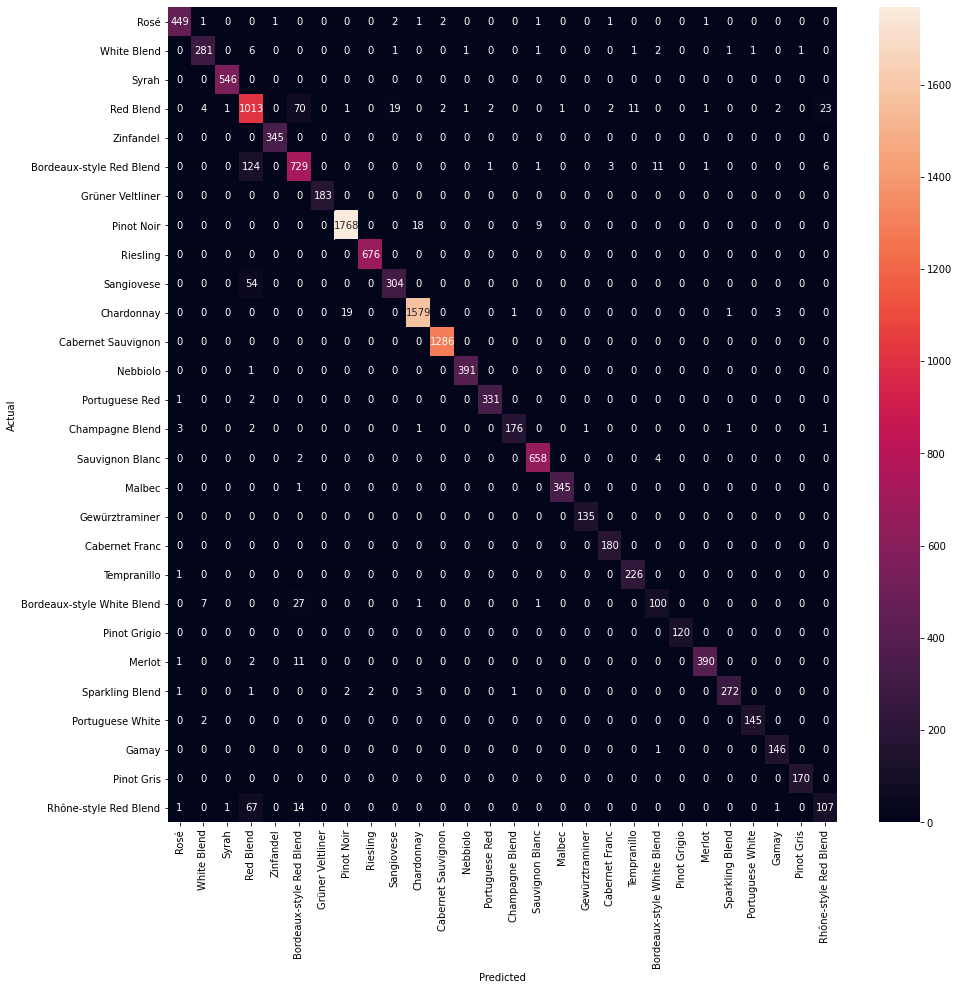

In [0]:
from sklearn.model_selection import train_test_split
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [0]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 100:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['variety', 'review_title']])
      print('')

'Bordeaux-style Red Blend' predicted as 'Red Blend' : 124 examples.


,variety,review_title
32581,Bordeaux-style Red Blend,Woodinville Wine Cellars 2013 Indomitable Red ...
27485,Bordeaux-style Red Blend,Yates Family Vineyard 2009 Alden Perry Reserve...
13526,Bordeaux-style Red Blend,Quilceda Creek 2009 Palengat Red Red (Horse He...
6540,Bordeaux-style Red Blend,Riglos 2009 Gran Corte Las Divas Vineyard Red ...
39484,Bordeaux-style Red Blend,Clos du Val 2007 Three Graces Blend Red (Napa ...
...,...,...
22647,Bordeaux-style Red Blend,Spier 2010 Creative Block 5 Red (Coastal Region)
2852,Bordeaux-style Red Blend,Walla Walla Vintners 2014 Washington State Cuv...
2111,Bordeaux-style Red Blend,Verité 2007 Le Desir Red (Sonoma County)
12286,Bordeaux-style Red Blend,Coho 2007 Headwaters Red (Napa Valley)


In [0]:
model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bordeaux-style Red Blend':
  . Top unigrams:
       . bordeaux
       . médoc
  . Top bigrams:
       . merlot cabernet
       . sauvignon merlot
# 'Bordeaux-style White Blend':
  . Top unigrams:
       . sauternes
       . barsac
  . Top bigrams:
       . bordeaux blanc
       . white bergerac
# 'Cabernet Franc':
  . Top unigrams:
       . chinon
       . franc
  . Top bigrams:
       . cabernet franc
       . saint nicolas
# 'Cabernet Sauvignon':
  . Top unigrams:
       . cabernet
       . sauvignon
  . Top bigrams:
       . cabernet sauvignon
       . red mountain
# 'Champagne Blend':
  . Top unigrams:
       . champagne
       . brut
  . Top bigrams:
       . brut champagne
       . rosé champagne
# 'Chardonnay':
  . Top unigrams:
       . chardonnay
       . chablis
  . Top bigrams:
       . beaujolais blanc
       . saint véran
# 'Gamay':
  . Top unigrams:
       . beaujolais
       . morgon
  . Top bigrams:
       . saint amour
       . moulin vent
# 'Gewürztraminer':
  . To

In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['variety'].unique()))

                            precision    recall  f1-score   support

                      Rosé       0.98      0.98      0.98       459
               White Blend       0.95      0.95      0.95       296
                     Syrah       1.00      1.00      1.00       546
                 Red Blend       0.80      0.88      0.84      1153
                 Zinfandel       1.00      1.00      1.00       345
  Bordeaux-style Red Blend       0.85      0.83      0.84       876
          Grüner Veltliner       1.00      1.00      1.00       183
                Pinot Noir       0.99      0.98      0.99      1795
                  Riesling       1.00      1.00      1.00       676
                Sangiovese       0.93      0.85      0.89       358
                Chardonnay       0.99      0.99      0.99      1603
        Cabernet Sauvignon       1.00      1.00      1.00      1286
                  Nebbiolo       0.99      1.00      1.00       392
            Portuguese Red       0.99      0.99

In [0]:
from joblib import dump,load

In [0]:
dump(tfidf,'tfidf_review_title.joblib')

['tfidf_review_title.joblib']

In [0]:
dump(model,'svm_review_title.joblib')

['svm_review_title.joblib']